In [58]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import metpy
import scipy.stats as sts
import re
from glob import glob
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.convection import dry_profile_temp
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, lapse_moist
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure
from isca_tools.utils.moist_physics import sphum_sat
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
from typing import Tuple
import os

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7

plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [3]:
def get_co2_multiplier(name):
    match = re.match(r'co2_([\d_]+)x', name)
    if match:
        # Replace underscore with decimal point and convert to float
        return float(match.group(1).replace('_', '.'))
    elif name == 'pre_industrial':
        return 1  # for pre_industrial or other defaults
    else:
        raise ValueError(f'Not valid name = {name}')

In [4]:
data_dir = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/3_hour/hottest_time'
exp_name = ['pre_industrial', 'co2_2x']
co2_vals = [1, 2]
n_exp = len(exp_name)
ds = [xr.load_dataset(os.path.join(data_dir, exp_name[i], 'output.nc')) for i in range(n_exp)]
ds = xr.concat(ds, dim=xr.DataArray(co2_vals, dims="co2", coords={"exp_name": ("co2", exp_name)}))

In [5]:
# Land masks
invariant_data_path = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc'
lsm = (xr.open_dataset(invariant_data_path).LANDFRAC > 0)
lsm = lsm.reindex_like(ds, method="nearest", tolerance=0.01)
ds['ZREFHT'] = cesm.load.load_z2m(invariant_data_path, var_reindex_like=ds.PS)

In [62]:
ds['P'] = cesm.get_pressure(ds.PS, ds.P0.isel(co2=0), ds.hyam.isel(co2=0), ds.hybm.isel(co2=0))
ds['T500'] = interp_hybrid_to_pressure(ds.T, ds.PS, ds.hyam.isel(co2=0), ds.hybm.isel(co2=0), ds.P0.isel(co2=0),
                                       np.atleast_1d(500 * 100)).load()
ds['Z500'] = interp_hybrid_to_pressure(ds.Z3, ds.PS, ds.hyam.isel(co2=0), ds.hybm.isel(co2=0), ds.P0.isel(co2=0),
                                       np.atleast_1d(500 * 100)).load()
ds['TREFHT'] = ds.T.isel(lev=-1)
ds['QREFHT'] = ds.Q.isel(lev=-1)
ds['ZREFHT'] = ds.Z3.isel(lev=-1)
ds['PREFHT'] = ds.P.isel(lev=-1)

In [7]:
ds['T500_zonal_daily_av_resize'] = ds.T500_zonal_daily_av.where(ds.time_max.dt.floor('D') == ds.time.dt.floor('D')).max(
    dim='time')

## LCL
Compare physical LCL to empirical LCL found by requiring error to dry profile less than threshold.

In [8]:
# Physical from lowest model level
ds['p_lcl'], ds['T_lcl'] = lcl_metpy(ds.T.isel(lev=-1), ds.Q.isel(lev=-1), ds.P.isel(lev=-1))

In [9]:
def find_lcl_empirical(temp_env, p_env, temp_start=None, p_start=None, temp_thresh=0.5):
    # Find LCL as the lowest pressure level where the deviation between environmental and dry profile is less than a threshold
    if temp_start is None:
        temp_start = temp_env.isel(lev=-1)
    if p_start is None:
        p_start = p_env.isel(lev=-1)
    mask = np.abs(temp_env - dry_profile_temp(temp_start, p_start, p_env)) > temp_thresh
    # Find highest pressure where deviation between t_env and t_dry is more than threshold. Then go to next highest pressure as LCL
    lcl_ind = ((mask.where(mask, other=np.nan) * np.arange(ds.lev.size)).max(dim='lev') + 1).astype(int)
    return p_env.isel(lev=lcl_ind), temp_env.isel(lev=lcl_ind)


ds['p_lcl_emp'], ds['T_at_lcl_emp'] = find_lcl_empirical(ds.T, ds.P)

In [10]:
def initialize_ax_projection(ax, lon_min=-180, lon_max=180, lat_min=30, lat_max=80,
                             grid_lon=np.arange(-180, 180.01, 60), grid_lat=np.asarray([-30, 30])):
    ax.coastlines(color='k', linewidth=1)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    gl = ax.gridlines(ccrs.PlateCarree(), xlocs=grid_lon, ylocs=grid_lat, linestyle=':',
                      color='k', alpha=1, draw_labels=True)
    gl.right_labels = 0
    gl.top_labels = 0
    return ax


def plot_contour_projection(ax, var, levels=None, n_levels=10, mask=lsm, cmap='viridis'):
    data, lon = add_cyclic_point(var if mask is None else var.where(mask), coord=var.lon.values, axis=1)
    if levels is None:
        levels = np.linspace(var.min(), var.max(), n_levels)
    im = ax.contourf(lon, var.lat.values, data, transform=ccrs.PlateCarree(),
                     levels=levels, extend='both', cmap=cmap)
    return im

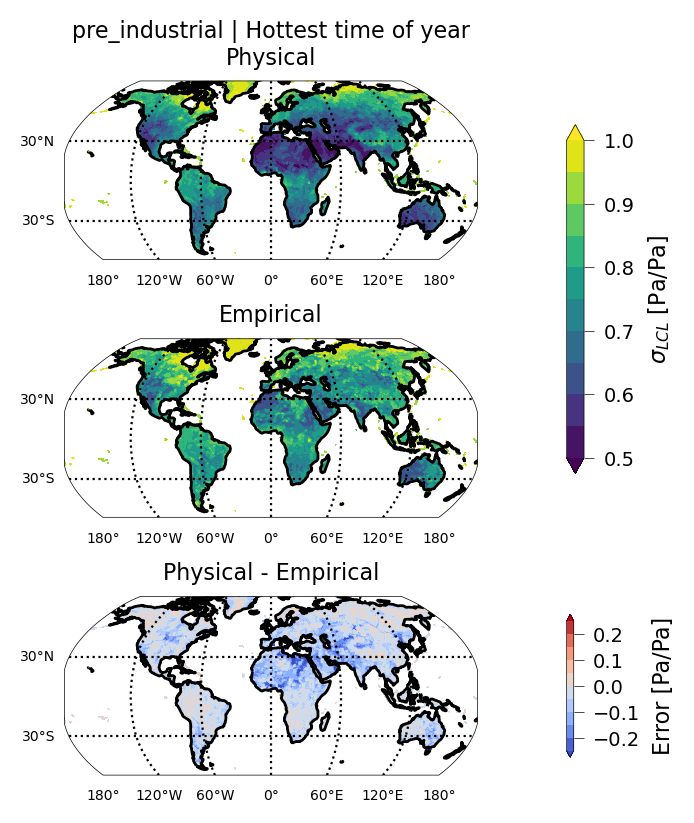

In [43]:
lat_plot_min = -60
lat_plot_max = 80

co2_ind = 0
fig = plt.figure(constrained_layout=True, figsize=(10., 4))
ax = fig.subplots(3, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
initialize_ax_projection(ax[0], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[1], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[2], lat_min=lat_plot_min, lat_max=lat_plot_max)

levels_use = np.arange(0.5, 1.05, 0.05)
plot_contour_projection(ax[0], (ds['p_lcl'] / ds.P.isel(lev=-1)).isel(co2=co2_ind),
                        cmap='viridis', levels=levels_use)
im = plot_contour_projection(ax[1], (ds['p_lcl_emp'] / ds.P.isel(lev=-1)).isel(co2=co2_ind), cmap='viridis',
                             levels=levels_use)
fig.colorbar(shrink=0.8, ax=ax[:2], label='$\sigma_{LCL}$ [Pa/Pa]', mappable=im)
im = plot_contour_projection(ax[2], (ds['p_lcl'] / ds.P.isel(lev=-1)).isel(co2=co2_ind) - (
        ds['p_lcl_emp'] / ds.P.isel(lev=-1)).isel(co2=co2_ind),
                             cmap='coolwarm', levels=np.arange(-0.25, 0.3, 0.05))

ax[0].set_title(f'{exp_name[co2_ind]} | Hottest time of year\nPhysical')
ax[1].set_title('Empirical')
ax[2].set_title('Physical - Empirical')
fig.colorbar(shrink=0.8, ax=ax[2], label='Error [Pa/Pa]', mappable=im)
# isca_tools.savefig(fig)
plt.show()

## Lapse Rate Error
Here, I compute the lapse rate between the LCL and 500hPa. Then I compute an error metric based on the individual lapse rates between model levels, and how these compare to the bulk lapse rate of the entire layer.

In [11]:
def rms_lapse_profile_1d(temp: np.ndarray, z: np.ndarray, p: np.ndarray, p_lcl: float,
                         t_upper: float,
                         z_upper: float,
                         gamma_ref: float,
                         p_upper: float = 500 * 100) -> Tuple[float, float, float, float]:
    """1D helper: RMS surface-proxy from one vertical profile."""

    # Mask between LCL and >upper limit
    if p_lcl < p_upper:
        return np.nan, np.nan, np.nan, np.nan
    mask = (p <= p_lcl) & (p > p_upper)
    temp_sel = temp[mask]
    z_sel = z[mask]
    p_sel = p[mask]

    # Append exact upper limit point
    temp_sel = np.concatenate([temp_sel, [t_upper]])
    z_sel = np.concatenate([z_sel, [z_upper]])
    p_sel = np.concatenate([p_sel, [p_upper]])

    # Sort descending p (surface to top)
    order = np.argsort(-p_sel)
    temp_sel = temp_sel[order]
    z_sel = z_sel[order]
    p_sel = p_sel[order]

    # Layerwise lapse rates
    dz = np.diff(z_sel)
    dT = np.diff(temp_sel)
    gamma = -dT / dz

    # Bulk lapse rate
    DeltaZ = np.abs(z_sel[0] - z_sel[-1])

    # Variance
    dev_sq = (gamma - gamma_ref) ** 2
    numerator = np.sum(dev_sq * dz)
    try:
        ind_max_error = np.argmax(dev_sq * dz)
    except ValueError as e:
        print(e)
        print(dz)
        print(p_sel)
        print(p_lcl)
    p_max_error = p_sel[ind_max_error]
    sigma_gamma = np.sqrt(numerator / DeltaZ)
    # print(np.sqrt((dev_sq * dz)[ind_max_error]))
    frac_max_error = np.sqrt((dev_sq * dz)[ind_max_error] / numerator)

    return sigma_gamma * 1000, DeltaZ, frac_max_error, p_max_error


def rms_lapse(ds: xr.Dataset) -> xr.DataArray:
    """Apply RMS lapse function across all points in dataset.

    ds must contain DataArrays:
      - temp(lev, ...) [K]
      - z(lev, ...)    [m]
      - p(lev, ...)    [Pa or hPa]
      - t500(...), z500(...), p_lcl(...), p_s(...)
    """
    out = xr.apply_ufunc(
        rms_lapse_profile_1d,
        ds.T,
        ds.Z3,
        ds.P,
        ds.p_lcl_emp + 1e-5,
        ds.T500,
        ds.Z500,
        ds.lapse_above_lcl / 1000,
        float(ds.plev),
        input_core_dims=[['lev'], ['lev'], ['lev'], [], [], [], [], []],
        output_core_dims=[[], [], [], []],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float, float, float, float],
    )
    # out.name = "RMS_T_surface_proxy"
    return out

In [13]:
ds['lapse_below_lcl'] = get_bulk_lapse_rate(ds.T.isel(lev=-1), ds.T_at_lcl_emp, ds.P.isel(lev=-1), ds.p_lcl_emp) * 1000
ds['lapse_below_lcl'] = ds['lapse_below_lcl'].fillna(
    lapse_dry * 1000)  # the regions where p_lcl = lowest model level, set to dry value

ds['lapse_above_lcl'] = get_bulk_lapse_rate(ds.T_at_lcl_emp, ds.T500, ds.p_lcl_emp, float(ds.plev)) * 1000

ds['lapse_above_lcl_error'], ds['lapse_above_lcl_zrange'], ds['lapse_above_lcl_error_frac'], ds[
    'lapse_above_lcl_error_p'] = rms_lapse(ds)

## Theoretical Temperature Decomposition
Decompose surface temperature into contributions from LCL height, lapse rates either side, and $T_{500}$.

In [67]:
def get_var_av(var, n_lat_av=30, mask=lsm):
    n_pad = n_lat_av // 2  # half window size
    # Pad edge with same values so can take average over latitude
    var_padded = var.where(mask).mean(dim="lon").pad(lat=(n_pad, n_pad), mode="edge")
    var_av = (var_padded.rolling(lat=n_lat_av, center=True).mean(dim="lat"))
    var_av = var_av.isel(lat=slice(n_pad, -n_pad))  # only return latitudes kept all along
    return var_av

In [187]:
mask_use = lsm.where(ds.p_lcl_emp > 550 * 100) > 0
ds['sigma_lcl_emp'] = ds['p_lcl_emp'] / ds.PREFHT
ds['sigma500'] = float(ds.plev) / ds['PREFHT']
ds['T500_zonal_daily_anom'] = ds.T500 - ds.T500_zonal_daily_av_resize
T_breakdown_av = {var: get_var_av(ds[var], mask=mask_use) for var in
                  ['T500_zonal_daily_av_resize', 'T500_zonal_daily_anom', 'p_lcl_emp', 'lapse_above_lcl',
                   'lapse_below_lcl', 'PREFHT', 'sigma_lcl_emp', 'sigma500']}
T_breakdown_av['T500'] = T_breakdown_av['T500_zonal_daily_av_resize'] + T_breakdown_av['T500_zonal_daily_anom']
# Compute average temperature from all the other average variables
T_breakdown_av['TREFHT'] = reconstruct_temp(T_breakdown_av['T500'], T_breakdown_av['PREFHT'],
                                            T_breakdown_av['sigma_lcl_emp'] * T_breakdown_av['PREFHT'], float(ds.plev),
                                            T_breakdown_av['lapse_below_lcl'] / 1000,
                                            T_breakdown_av['lapse_above_lcl'] / 1000)

T_breakdown_anom = {var: ds[var] - T_breakdown_av[var] for var in T_breakdown_av}

T_breakdown_cont = {}
T_breakdown_cont['T500_zonal_daily_av_resize'] = reconstruct_temp(
    T_breakdown_av['T500'] + T_breakdown_anom['T500_zonal_daily_av_resize'],
    T_breakdown_av['PREFHT'],
    T_breakdown_av['sigma_lcl_emp'] * T_breakdown_av['PREFHT'], float(ds.plev),
    T_breakdown_av['lapse_below_lcl'] / 1000,
    T_breakdown_av['lapse_above_lcl'] / 1000) - T_breakdown_av['TREFHT']

T_breakdown_cont['T500_zonal_daily_anom'] = reconstruct_temp(
    T_breakdown_av['T500'] + T_breakdown_anom['T500_zonal_daily_anom'],
    T_breakdown_av['PREFHT'],
    T_breakdown_av['sigma_lcl_emp'] * T_breakdown_av['PREFHT'], float(ds.plev),
    T_breakdown_av['lapse_below_lcl'] / 1000,
    T_breakdown_av['lapse_above_lcl'] / 1000) - T_breakdown_av['TREFHT']

T_breakdown_cont['sigma_lcl_emp'] = reconstruct_temp(
    T_breakdown_av['T500'],
    T_breakdown_av['PREFHT'],
    (T_breakdown_av['sigma_lcl_emp'] + T_breakdown_anom['sigma_lcl_emp']) * T_breakdown_av['PREFHT'], float(ds.plev),
    T_breakdown_av['lapse_below_lcl'] / 1000,
    T_breakdown_av['lapse_above_lcl'] / 1000) - T_breakdown_av['TREFHT']

T_breakdown_cont['sigma500'] = reconstruct_temp(
    T_breakdown_av['T500'],
    T_breakdown_av['PREFHT'] + T_breakdown_anom['PREFHT'],
    T_breakdown_av['sigma_lcl_emp'] * (T_breakdown_av['PREFHT'] + T_breakdown_anom['PREFHT']), float(ds.plev),
    T_breakdown_av['lapse_below_lcl'] / 1000,
    T_breakdown_av['lapse_above_lcl'] / 1000) - T_breakdown_av['TREFHT']

T_breakdown_cont['lapse_below_lcl'] = reconstruct_temp(
    T_breakdown_av['T500'],
    T_breakdown_av['PREFHT'],
    T_breakdown_av['sigma_lcl_emp'] * T_breakdown_av['PREFHT'], float(ds.plev),
    (T_breakdown_av['lapse_below_lcl'] + T_breakdown_anom['lapse_below_lcl']) / 1000,
    T_breakdown_av['lapse_above_lcl'] / 1000) - T_breakdown_av['TREFHT']

T_breakdown_cont['lapse_above_lcl'] = reconstruct_temp(
    T_breakdown_av['T500'],
    T_breakdown_av['PREFHT'],
    T_breakdown_av['sigma_lcl_emp'] * T_breakdown_av['PREFHT'], float(ds.plev),
    T_breakdown_av['lapse_below_lcl'] / 1000,
    (T_breakdown_av['lapse_above_lcl'] + T_breakdown_anom['lapse_above_lcl']) / 1000) - T_breakdown_av['TREFHT']


# T_breakdown_sensitivity = {'T500_zonal_daily_av_resize': T_breakdown_av['TREFHT'] / T_breakdown_av['T500'],
#                            'T500_zonal_daily_anom': T_breakdown_av['TREFHT'] / T_breakdown_av['T500'],
#                            'lapse_below_lcl': -(T_breakdown_av['TREFHT'] * np.log(T_breakdown_av['sigma_lcl_emp'])) * R / g / 1000,
#                            'lapse_above_lcl': (T_breakdown_av['TREFHT'] * np.log(T_breakdown_av['sigma_lcl_emp'])) * R / g / 1000,
#                            'sigma_lcl_emp': R / g * ((T_breakdown_av['lapse_above_lcl'] - T_breakdown_av['lapse_below_lcl']) / 1000 / T_breakdown_av['sigma_lcl_emp'] * T_breakdown_av['TREFHT']),
#                            'sigma500': -R / g * (T_breakdown_av['lapse_above_lcl'] / 1000 / T_breakdown_av['sigma500'] * T_breakdown_av['TREFHT'])}
#
#
# T_breakdown_cont = {key: T_breakdown_anom[key] * T_breakdown_sensitivity[key]
#                               for key in T_breakdown_sensitivity}
T_anom_theory = sum(T_breakdown_cont.values()).isel(plev=0)
# T_anom_theory = sum(T_breakdown_cont.values()).isel(plev=0)

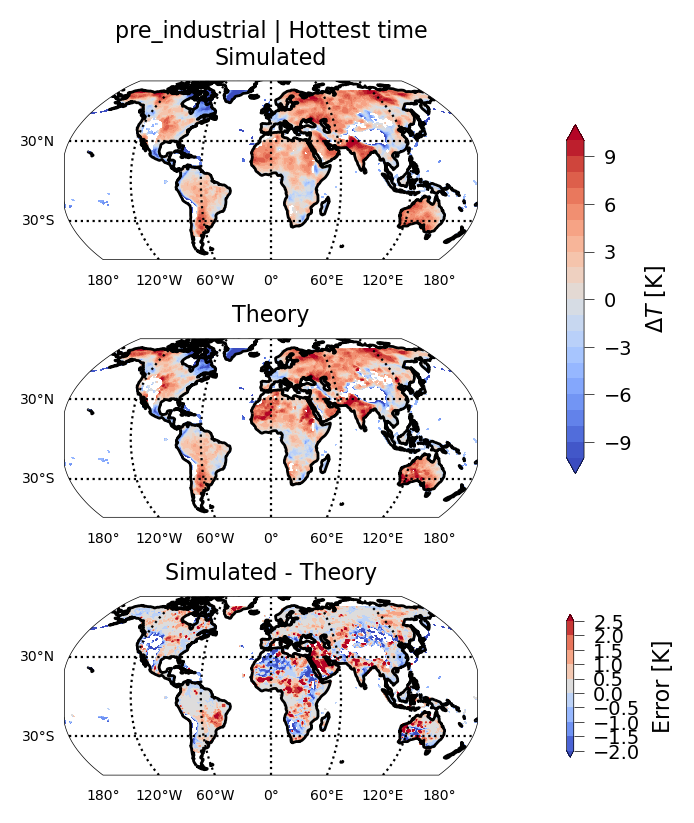

In [188]:
lat_plot_min = -60
lat_plot_max = 80
# norm_by_av = 'FT'
co2_ind = 0
fig = plt.figure(constrained_layout=True, figsize=(10., 4))
ax = fig.subplots(3, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
initialize_ax_projection(ax[0], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[1], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[2], lat_min=lat_plot_min, lat_max=lat_plot_max)

levels_use = np.arange(-10, 11, 1)
plot_contour_projection(ax[0], T_breakdown_anom['TREFHT'].isel(co2=co2_ind, plev=0),
                        cmap='coolwarm', levels=levels_use, mask=mask_use.isel(co2=co2_ind))
im = plot_contour_projection(ax[1], T_anom_theory.isel(co2=co2_ind), cmap='coolwarm', levels=levels_use,
                             mask=mask_use.isel(co2=co2_ind))
fig.colorbar(shrink=0.8, ax=ax[:2], label='$\Delta T$ [K]', mappable=im)
im = plot_contour_projection(ax[2],
                             T_breakdown_anom['TREFHT'].isel(co2=co2_ind, plev=0) - T_anom_theory.isel(co2=co2_ind),
                             cmap='coolwarm', levels=np.arange(-2, 3, 0.5), mask=mask_use.isel(co2=co2_ind))
# # im = plot_contour_projection(ax[1], var_theory,
# #                              levels=levels_temp_change[norm_by_av],
# #                              cmap='coolwarm' if norm_by_av else 'viridis')
ax[0].set_title(f'{exp_name[co2_ind]} | Hottest time\nSimulated')
ax[1].set_title('Theory')
ax[2].set_title('Simulated - Theory')
fig.colorbar(shrink=0.8, ax=ax[2], label='Error [K]', mappable=im)
# isca_tools.savefig(fig)
plt.show()

### Contribution from each mechanism
Below, I look at the contribution from each mechanism in causing a region to be anomalously warm in a given climate compared to the spatial average.

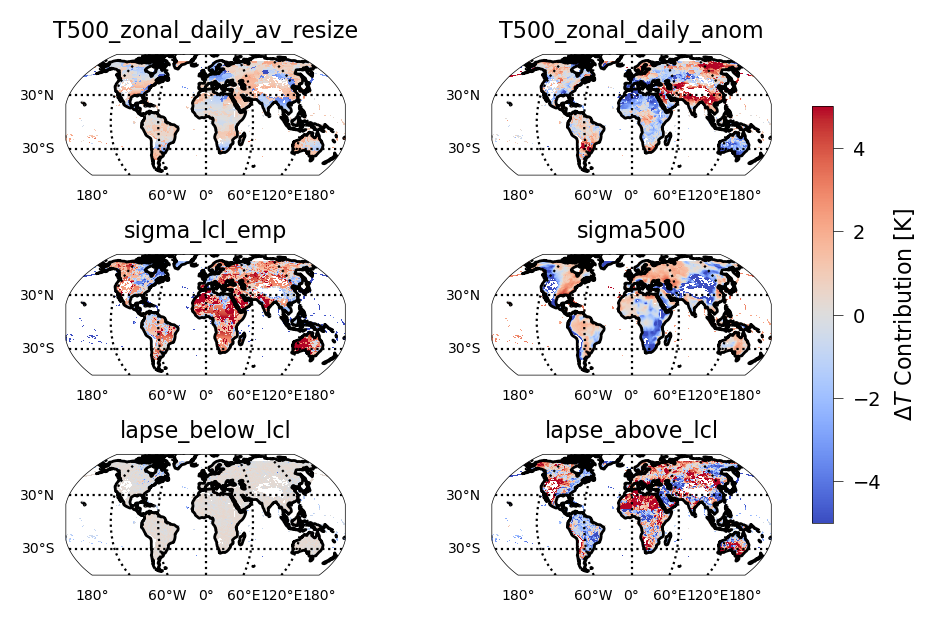

In [193]:
co2_ind=0
fig = plt.figure(constrained_layout=True,figsize=(10/2,6/2))
ax = fig.subplots(3,2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
ax = ax.flatten()
for i, key in enumerate(T_breakdown_cont):
    initialize_ax_projection(ax[i], lat_min=lat_plot_min, lat_max=lat_plot_max)
    im = ax[i].pcolormesh(ds.lon.values, ds.lat.values, T_breakdown_cont[key].isel(co2=co2_ind, plev=0).where(mask_use.isel(co2=co2_ind)),
                        transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=-5, vmax=5)
    ax[i].set_title(key.replace('_zonal_daily', '').replace('_resize', ''))
    # im = plot_contour_projection(ax[i], TREFHT_anom_breakdown_cont[key].isel(co2=co2_ind),
    #                              cmap='coolwarm', levels=np.arange(-15, 20, 2.5))
#     fig.colorbar(shrink=0.8, ax=ax[i], label=f'{name_breakdown[key]} [K]', mappable=im)
fig.colorbar(shrink=0.8, ax=ax.ravel(), label=f'$\Delta T$ Contribution [K]', mappable=im)
# fig.suptitle(f'$\Delta T_{"{REFHT}"}$ Breakdown\n{exp_labels[co2_ind]} | $(x={quant[1]}) - (x={quant[0]})$')
plt.show()

### $T_s$ error due to $\Gamma$ error
Below I compute the error in the surface temperature due to the variation in the lapse rate above the LCL i.e. due to fact it is not constant between LCL and 500hPa.

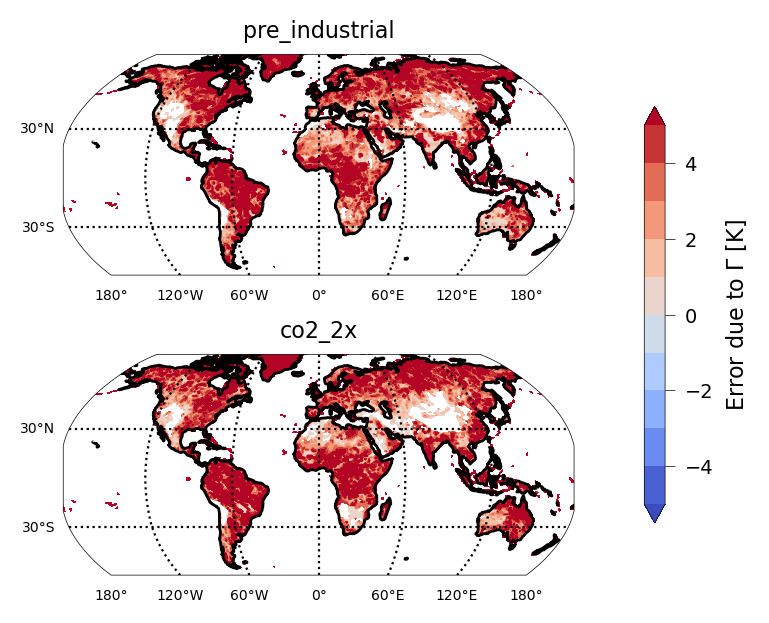

In [217]:
temp_error_lapse = ds['lapse_above_lcl_error'] * ds['lapse_above_lcl_zrange']/1000 * (ds.PREFHT/ds.p_lcl_emp)**(R*ds.lapse_below_lcl/1000/g)
lat_plot_min = -60
lat_plot_max = 80
levels_use = np.arange(-5, 6, 1)
fig = plt.figure(constrained_layout=True, figsize=(8., 3))
ax = fig.subplots(2, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
initialize_ax_projection(ax[0], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[1], lat_min=lat_plot_min, lat_max=lat_plot_max)

for i in range(n_exp):
    im = plot_contour_projection(ax[i], temp_error_lapse.isel(co2=i, plev=0), cmap='coolwarm', levels=levels_use,
                                 mask=mask_use.isel(co2=i))
    ax[i].set_title(exp_name[i])
fig.colorbar(shrink=0.8, ax=ax.ravel(), label='Error due to $\Gamma$ [K]', mappable=im)
plt.show()

## Change in spatial anomaly with warming
Next we take the above plot indicating what is causing the spatial variation in $T_s$ in a given climate, but instead plot the difference between climates.

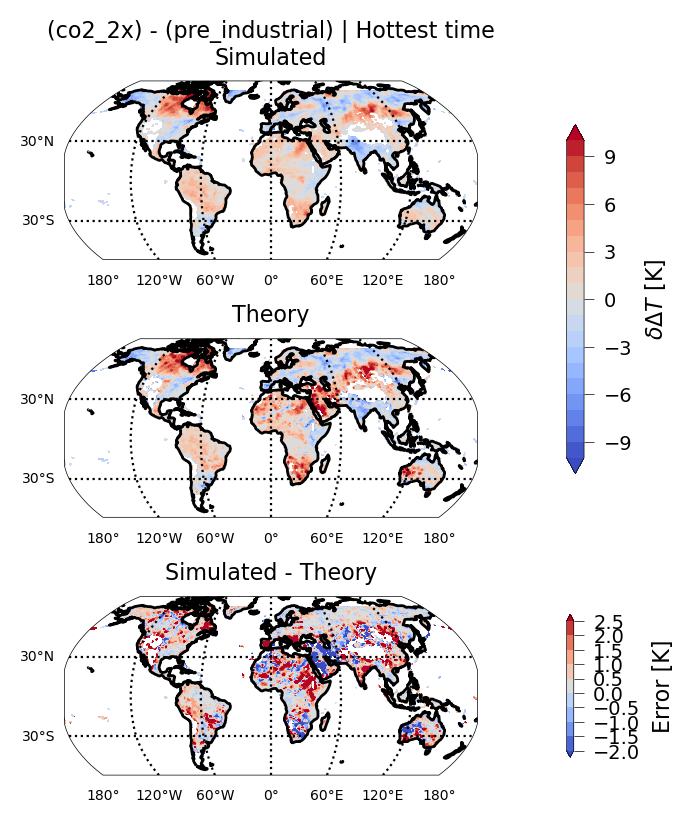

In [218]:
lat_plot_min = -60
lat_plot_max = 80
# norm_by_av = 'FT'
co2_ind = 0
fig = plt.figure(constrained_layout=True, figsize=(10., 4))
ax = fig.subplots(3, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
initialize_ax_projection(ax[0], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[1], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[2], lat_min=lat_plot_min, lat_max=lat_plot_max)

levels_use = np.arange(-10, 11, 1)
plot_contour_projection(ax[0], T_breakdown_anom['TREFHT'].isel(co2=1, plev=0) - T_breakdown_anom['TREFHT'].isel(co2=0, plev=0),
                        cmap='coolwarm', levels=levels_use, mask=mask_use.isel(co2=0))
im = plot_contour_projection(ax[1], T_anom_theory.isel(co2=1) - T_anom_theory.isel(co2=0), cmap='coolwarm', levels=levels_use,
                             mask=mask_use.isel(co2=0))
fig.colorbar(shrink=0.8, ax=ax[:2], label='$\delta \Delta T$ [K]', mappable=im)
im = plot_contour_projection(ax[2],
                             T_breakdown_anom['TREFHT'].isel(co2=1, plev=0) - T_breakdown_anom['TREFHT'].isel(co2=0, plev=0) -
                             (T_anom_theory.isel(co2=1) - T_anom_theory.isel(co2=0)),
                             cmap='coolwarm', levels=np.arange(-2, 3, 0.5), mask=mask_use.isel(co2=co2_ind))
# # im = plot_contour_projection(ax[1], var_theory,
# #                              levels=levels_temp_change[norm_by_av],
# #                              cmap='coolwarm' if norm_by_av else 'viridis')
ax[0].set_title(f'({exp_name[1]}) - ({exp_name[0]}) | Hottest time\nSimulated')
ax[1].set_title('Theory')
ax[2].set_title('Simulated - Theory')
fig.colorbar(shrink=0.8, ax=ax[2], label='Error [K]', mappable=im)
# isca_tools.savefig(fig)
plt.show()

#### Contribution to change with warming
Below I plot the mechanisms contributing to the change with warming.

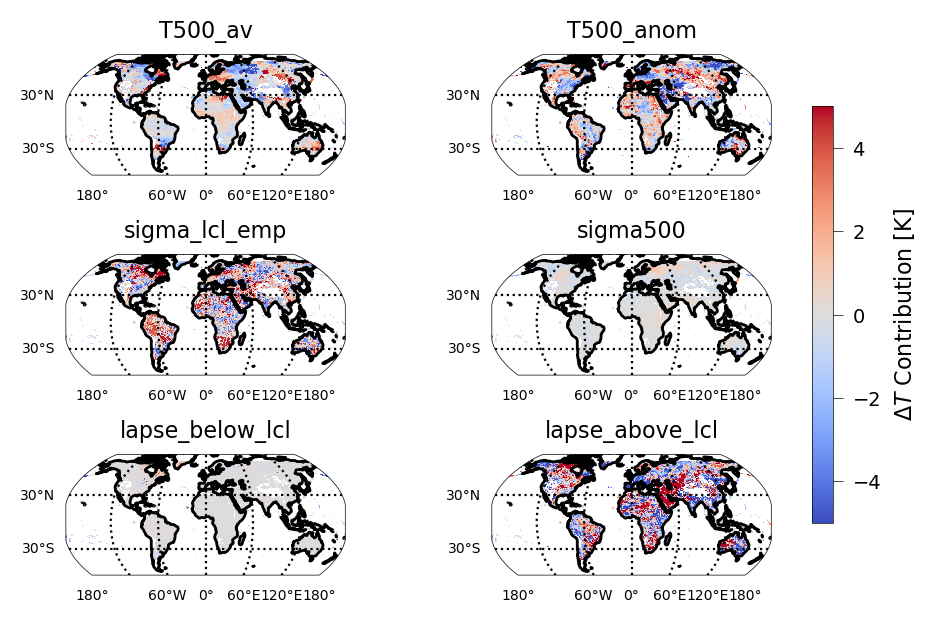

In [210]:
fig = plt.figure(constrained_layout=True,figsize=(10/2,6/2))
ax = fig.subplots(3,2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
ax = ax.flatten()
for i, key in enumerate(T_breakdown_cont):
    initialize_ax_projection(ax[i], lat_min=lat_plot_min, lat_max=lat_plot_max)
    im = ax[i].pcolormesh(ds.lon.values, ds.lat.values, (T_breakdown_cont[key].isel(co2=1, plev=0) -
                                                         T_breakdown_cont[key].isel(co2=0, plev=0)).where(mask_use.isel(co2=co2_ind)),
                        transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=-5, vmax=5)
    ax[i].set_title(key.replace('_zonal_daily', '').replace('_resize', ''))
    # im = plot_contour_projection(ax[i], TREFHT_anom_breakdown_cont[key].isel(co2=co2_ind),
    #                              cmap='coolwarm', levels=np.arange(-15, 20, 2.5))
#     fig.colorbar(shrink=0.8, ax=ax[i], label=f'{name_breakdown[key]} [K]', mappable=im)
fig.colorbar(shrink=0.8, ax=ax.ravel(), label=f'$\delta \Delta T$ Contribution [K]', mappable=im)
# fig.suptitle(f'$\Delta T_{"{REFHT}"}$ Breakdown\n{exp_labels[co2_ind]} | $(x={quant[1]}) - (x={quant[0]})$')
plt.show()